<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Microbial-and-Viral-differentials" data-toc-modified-id="Microbial-and-Viral-differentials-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Microbial and Viral differentials</a></span></li><li><span><a href="#Viral-differentials" data-toc-modified-id="Viral-differentials-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Viral differentials</a></span></li></ul></div>

In [1]:
import os
import arviz as az
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import networkx as nx
import seaborn as sns
import matplotlib as mpl

from matplotlib_venn import venn2, venn3
np.random.seed(0)
%matplotlib inline

In [2]:
all_edges = pd.read_table('../results/interaction_metadata.txt', index_col=0)

In [3]:
graph = nx.from_pandas_edgelist(all_edges, 'microbe', 'virus')

In [4]:
nx.number_connected_components(graph)

2

In [5]:
components = nx.connected_components(graph)
#c1 = next(components)
#c2 = next(components)
for c in components:
    print('Nodes', len(c))

Nodes 213
Nodes 3


In [6]:
pos = nx.spring_layout(graph, k=3, iterations=500)
pos_df = pd.DataFrame(pos).T

In [7]:
microbe_nodes = pd.merge(all_edges, pos_df, left_on='microbe', right_index=True)
virus_nodes = pd.merge(all_edges, pos_df, left_on='virus', right_index=True)

microbe_nodes = microbe_nodes.set_index('microbe').drop_duplicates()
virus_nodes = virus_nodes.set_index('virus').drop_duplicates()

microbe_nodes = microbe_nodes[~microbe_nodes.index.duplicated(keep='first')]
virus_nodes = virus_nodes[~virus_nodes.index.duplicated(keep='first')]

species_pos = microbe_nodes.groupby('species').mean()
genus_pos = microbe_nodes.groupby('genus').mean()

# Microbial and Viral differentials

In [8]:
# load 16S, whole genome shotgun and RNAseq data
from util import extract_differentials, ranking
wgs_directory = '../sfari/data/sra_shotgun/Combined'
posterior_name = 'age_sex_matched_posterior'
wgs_fname = f'{wgs_directory}/{posterior_name}/ogus_differentials-v3.nc'
vir_fname = f'{wgs_directory}/{posterior_name}/viral_differentials-v3.nc'

wgs_diffs = extract_differentials(wgs_fname)
vir_diffs = extract_differentials(vir_fname)

# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
wgs_stats = ranking(wgs_diffs, reference_percentile=90)
vir_stats = ranking(vir_diffs, reference_percentile=90)

In [9]:
microbe_nodes.index = list(map(str, microbe_nodes.index))
microbe_nodes = pd.merge(microbe_nodes, wgs_stats, left_index=True, right_index=True)
microbe_nodes['diff'] = microbe_nodes['mean']

virus_nodes.index = list(map(str, virus_nodes.index))
virus_nodes = pd.merge(virus_nodes, vir_stats, left_index=True, right_index=True)
virus_nodes['diff'] = virus_nodes['mean']

# Viral differentials

In [10]:
coords = {
    'Klebsiella': {'dx': -0.45, 'dy': 0.01},
    'Escherichia': {'dx': -0.58, 'dy': 0.01},
    'Bacteroides': {'dx': 0.08, 'dy': 0.0},
    'Veillonella': {'dx': 0, 'dy': -0.1},
    'Collinsella': {'dx': -0.55, 'dy': 0.01},
    'Tidjanibacter': {'dx': -0.3, 'dy': 0.05},
}

Alistipes
Bacteroides
Collinsella
Escherichia
Klebsiella
Tidjanibacter
Veillonella


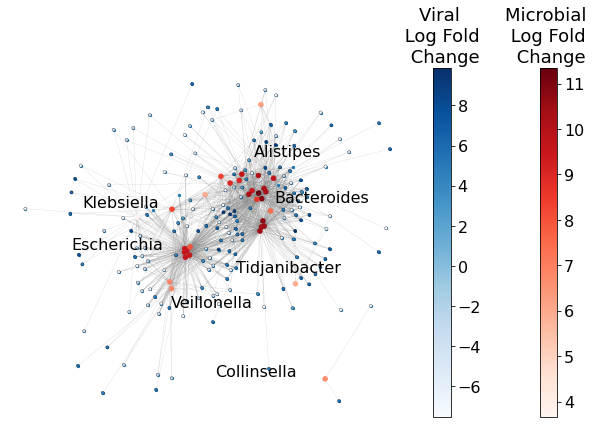

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))
nx.draw(graph, pos=pos, node_size=5, width=0.1, edge_color='gray')
cbar1 = ax.scatter(microbe_nodes[0], microbe_nodes[1], s=20, zorder=2, 
                   c=microbe_nodes['diff'], cmap='Reds')
cbar2 = ax.scatter(virus_nodes[0], virus_nodes[1], s=10, zorder=2, 
                   c=virus_nodes['diff'], cmap='Blues', ec='k', lw=0.3)

clb1 = plt.colorbar(cbar1)
clb2 = plt.colorbar(cbar2)
clb1.ax.tick_params(labelsize=16) 
clb2.ax.tick_params(labelsize=16) 
clb1.ax.set_title('Microbial \n Log Fold \n Change', fontsize=18)
clb2.ax.set_title('Viral \n Log Fold \n Change', fontsize=18)

for s in genus_pos.index:
    row = genus_pos.loc[s]
    if row.name in {'Citrobacter', 'Megamonas', 'Mitsuokella'}:
        continue
    genus_name = row.name.replace(' ', '\n')
    print(genus_name)
    if genus_name in coords:
        dx, dy = coords[genus_name]['dx'], coords[genus_name]['dy']
    else:
        dx, dy = 0.02, 0.01
    ax.annotate(genus_name, (row[0] + dx, row[1] + dy), 
                fontsize=16, 
                color='k')
#ax.set_facecolor('black')
#fig.set_facecolor('black')
plt.tight_layout()

In [12]:
species_pos = microbe_nodes.groupby('genus').mean()

In [13]:
row.name

'Veillonella'

In [14]:
row[0]

-0.2737351698113051

In [15]:
genus_pos

,cond_logit,GPD_VC,Size,checkV_completion,0,1
genus,,,,,,
Alistipes,1.591010,12411.75,47141.75,96.955,0.124319,0.284025
Bacteroides,2.295354,15310.00,53062.00,100.000,0.167361,0.090296
Citrobacter,1.015043,15310.00,53062.00,100.000,-0.100759,0.123073
Collinsella,2.108800,2153.00,16251.00,97.200,0.499891,-0.702163
Escherichia,3.008392,18797.00,40415.00,100.000,-0.192135,-0.133208
Klebsiella,1.303252,15310.00,53062.00,100.000,-0.266682,0.057487
Megamonas,3.535686,15310.00,53062.00,100.000,0.023984,0.174862
Mitsuokella,1.746101,15310.00,53062.00,100.000,-0.442616,0.022321
Tidjanibacter,1.173307,908.00,119423.00,NaN,0.351324,-0.276334


In [16]:
!ls ../results

16S_compounds.csv		  metabolomics
16S_KEGG.csv			  mmvec
amp_compound_edges.npz.npy	  rna_compound_edges.npz.npy
amp_compound_edges.parquet	  rna_compound_edges.parquet
amp-crossectional.csv		  RNA_compounds.csv
amp-crossectional-studies.csv	  RNA_KEGG.csv
amp-logodds.csv			  seqs.fa
asd_core_microbiome_fmt.csv	  t1d__kegg_set.csv
asd_diabetes_differential.csv	  t1d__taxa_set.csv
asd_ibd_differential.csv	  top_asd_dia_specific_taxa.csv
asd_ibd_kegg_set.csv		  top_asd_specific_taxa.csv
asd_ibd_taxa_set.csv		  top_asd_taxa.csv
asd__kegg_set.csv		  top_diabetes_taxa.csv
asd_specific_microbiome_fmt.csv   top_dia_specific_taxa.csv
asd_t1d_kegg_set.csv		  top_ibd_asd_specific_taxa.csv
asd_t1d_taxa_set.csv		  top_ibd_dia_specific_taxa.csv
asd__taxa_set.csv		  top_ibd_specific_taxa.csv
benchmarking			  top_ibd_taxa.csv
berding_diet_microbes.csv	  tree.nwk
berding_diet_stats.csv		  week0_100_fmt_ranks.csv
classification			  week0_10_fmt_ranks.csv
compound_positions.csv		  week0_18_fmt_ranks.csv

In [17]:
microbe_nodes.to_csv('microbe-viral-interactions.csv')

In [18]:
vir_stats 

,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue
features,,,,,,,,,
ivig_10,3.124860,1.799529,0.580344,2.976912,6.545455,0.964967,0.308803,-36.427270,5.822513e-129
ivig_1001,3.988176,1.383442,1.962330,3.863774,6.491225,2.083781,0.522490,-34.902513,2.563667e-123
ivig_1002,-7.096443,2.931017,-11.859461,-6.709995,-2.945768,-0.826046,0.116403,-92.110695,5.805531e-271
ivig_1113,-6.610124,2.909068,-11.454334,-6.433497,-2.290182,-0.781091,0.118166,-89.462190,3.858833e-266
ivig_1131,5.082723,2.208299,2.008469,4.688980,8.977809,1.042271,0.205061,-11.952495,2.349465e-28
...,...,...,...,...,...,...,...,...,...
uvig_98139,-7.831613,2.607439,-12.650095,-7.397144,-4.084338,-1.151922,0.147086,-109.180482,2.691092e-299
uvig_98916,7.900113,0.297580,7.428390,7.887216,8.384367,89.212397,11.292547,100.655615,1.058306e-285
uvig_9921,5.605423,1.482199,3.591802,5.407682,7.996080,2.551499,0.455184,-10.754752,7.356387e-24


In [19]:
virus_nodes

,microbe,cond_logit,dataset,GPD_id,Source,GPD_VC,Size,Predicted_phage_taxon,Host_range_isolates,Host_range_taxon,...,mean,std,5%,50%,95%,effect_size,effect_std,tstat,pvalue,diff
ivig_2376,29466,4.949254,Wang,ivig_2376,Isolate,18797,40415,NaN,GCF_000011045,Firmicutes/Bacilli/Lactobacillales/Lactobacill...,...,-6.700509,2.849265,-11.887684,-6.398666,-2.478428,-0.825357,0.123178,-91.974353,1.020960e-270,-6.700509
ivig_2256,29466,4.537919,Wang,ivig_2256,Isolate,41768,39592,NaN,GCA_003602765,Firmicutes/Negativicutes/Veillonellales/Veillo...,...,-7.068940,2.653144,-12.274386,-6.588235,-3.679106,-1.004229,0.142062,-101.550456,3.534940e-287,-7.068940
uvig_108002,29466,4.431313,Wang,uvig_108002,Metagenome,37815,32601,Myoviridae,"GCA_003464755,GCF_000164195,12718_7#19,20298_3...",Proteobacteria/Gammaproteobacteria/Enterobacte...,...,-6.953425,3.050820,-13.099778,-6.530817,-2.740553,-0.747078,0.107440,-87.556027,1.374176e-262,-6.953425
ivig_2624,29466,2.595860,Wang,ivig_2624,Isolate,18608,36252,Myoviridae,GCF_000164315,Proteobacteria/Gammaproteobacteria/Enterobacte...,...,5.830689,2.589796,2.035767,5.476299,10.311843,0.869338,0.149097,-4.415546,1.299048e-05,5.830689
ivig_115,29466,2.593550,Wang,ivig_115,Isolate,40689,10600,NaN,GCA_003435265,Firmicutes/Clostridia/Lachnospirales/Lachnospi...,...,6.771045,2.623625,2.541106,6.753981,10.911522,0.983676,0.145277,2.809761,5.201848e-03,6.771045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uvig_428680,500635,1.740638,Averina,uvig_428680,Metagenome,6450,10040,NaN,"GCA_003474665,GCA_003477985,GCA_003473325",Firmicutes/Clostridia/Lachnospirales/Lachnospi...,...,-3.017744,4.177843,-10.393870,-2.678798,3.117314,-0.172893,0.057292,-45.096003,1.025877e-158,-3.017744
uvig_376615,500635,1.507507,Averina,uvig_376615,Metagenome,16797,44313,NaN,"GCA_003469775,GCA_003470105,GCA_003464475,GCA_...",Bacteroidota/Bacteroidia/Bacteroidales/Tannere...,...,-7.218092,2.954791,-12.147025,-6.978472,-2.927235,-0.826740,0.114537,-92.192969,4.131033e-271,-7.218092
uvig_14714,500635,1.477428,Averina,uvig_14714,Metagenome,43599,11706,NaN,GCA_003479625,Firmicutes/Clostridia/Lachnospirales/Lachnospi...,...,6.341146,2.640532,2.807923,5.744488,11.655009,0.909463,0.143422,-0.464386,6.426245e-01,6.341146
uvig_328002,411903,2.108800,Wang,uvig_328002,Metagenome,2153,16251,NaN,"GCA_003473115,GCA_003458335,GCA_003474015,GCA_...",Actinobacteriota/Actinobacteria/Actinomycetale...,...,-6.783517,2.770566,-11.558983,-6.568847,-2.543889,-0.883727,0.130276,-95.186135,2.088313e-276,-6.783517


In [20]:
pd.merge(virus_nodes, vir_stats, left_index=True, right_index=True)

,microbe,cond_logit,dataset,GPD_id,Source,GPD_VC,Size,Predicted_phage_taxon,Host_range_isolates,Host_range_taxon,...,diff,mean_y,std_y,5%_y,50%_y,95%_y,effect_size_y,effect_std_y,tstat_y,pvalue_y
ivig_2376,29466,4.949254,Wang,ivig_2376,Isolate,18797,40415,NaN,GCF_000011045,Firmicutes/Bacilli/Lactobacillales/Lactobacill...,...,-6.700509,-6.700509,2.849265,-11.887684,-6.398666,-2.478428,-0.825357,0.123178,-91.974353,1.020960e-270
ivig_2256,29466,4.537919,Wang,ivig_2256,Isolate,41768,39592,NaN,GCA_003602765,Firmicutes/Negativicutes/Veillonellales/Veillo...,...,-7.068940,-7.068940,2.653144,-12.274386,-6.588235,-3.679106,-1.004229,0.142062,-101.550456,3.534940e-287
uvig_108002,29466,4.431313,Wang,uvig_108002,Metagenome,37815,32601,Myoviridae,"GCA_003464755,GCF_000164195,12718_7#19,20298_3...",Proteobacteria/Gammaproteobacteria/Enterobacte...,...,-6.953425,-6.953425,3.050820,-13.099778,-6.530817,-2.740553,-0.747078,0.107440,-87.556027,1.374176e-262
ivig_2624,29466,2.595860,Wang,ivig_2624,Isolate,18608,36252,Myoviridae,GCF_000164315,Proteobacteria/Gammaproteobacteria/Enterobacte...,...,5.830689,5.830689,2.589796,2.035767,5.476299,10.311843,0.869338,0.149097,-4.415546,1.299048e-05
ivig_115,29466,2.593550,Wang,ivig_115,Isolate,40689,10600,NaN,GCA_003435265,Firmicutes/Clostridia/Lachnospirales/Lachnospi...,...,6.771045,6.771045,2.623625,2.541106,6.753981,10.911522,0.983676,0.145277,2.809761,5.201848e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uvig_428680,500635,1.740638,Averina,uvig_428680,Metagenome,6450,10040,NaN,"GCA_003474665,GCA_003477985,GCA_003473325",Firmicutes/Clostridia/Lachnospirales/Lachnospi...,...,-3.017744,-3.017744,4.177843,-10.393870,-2.678798,3.117314,-0.172893,0.057292,-45.096003,1.025877e-158
uvig_376615,500635,1.507507,Averina,uvig_376615,Metagenome,16797,44313,NaN,"GCA_003469775,GCA_003470105,GCA_003464475,GCA_...",Bacteroidota/Bacteroidia/Bacteroidales/Tannere...,...,-7.218092,-7.218092,2.954791,-12.147025,-6.978472,-2.927235,-0.826740,0.114537,-92.192969,4.131033e-271
uvig_14714,500635,1.477428,Averina,uvig_14714,Metagenome,43599,11706,NaN,GCA_003479625,Firmicutes/Clostridia/Lachnospirales/Lachnospi...,...,6.341146,6.341146,2.640532,2.807923,5.744488,11.655009,0.909463,0.143422,-0.464386,6.426245e-01
uvig_328002,411903,2.108800,Wang,uvig_328002,Metagenome,2153,16251,NaN,"GCA_003473115,GCA_003458335,GCA_003474015,GCA_...",Actinobacteriota/Actinobacteria/Actinomycetale...,...,-6.783517,-6.783517,2.770566,-11.558983,-6.568847,-2.543889,-0.883727,0.130276,-95.186135,2.088313e-276
